In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os

# Check if MPS (Apple Silicon) or CUDA is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data transformations (96x96 resizing)
data_transforms = transforms.Compose([
    transforms.Resize((96, 96)),            # Resize to 96x96 pixels
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset (without splitting into train/val yet)
data_dir = '/Users/shingkai/code/personal-projects/mk8/training_data/positions/train'
# data_dir = '/home/itsgrimetime/code/MarioKart8CV/items'
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Split dataset into train and validation sets
train_size = int(0.8 * len(full_dataset))   # 80% training
val_size = len(full_dataset) - train_size   # 20% validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}

# Get number of classes
num_classes = len(full_dataset.classes)

# Load MobileNetV3-large pre-trained model
model = models.mobilenet_v3_large(pretrained=True)

# Modify the last fully connected layer to match the number of classes
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

# Move model to the GPU if available
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Fine-tune the model
model = train_model(model, criterion, optimizer, dataloaders, num_epochs=5)

# Save the trained model
torch.save(model.state_dict(), '../models/position_classifier_mobilenetv3.pth')

/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5
----------


KeyboardInterrupt: 

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import cv2
from PIL import Image
import numpy as np

classes = ['00','01',"02","03","04","05","06","07","08","09","10","11","12"]

# Check if MPS (Apple Silicon) or CUDA is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned MobileNetV3 model
num_classes = len(classes)  # Change this based on your number of classes
model = models.mobilenet_v3_large(pretrained=False)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model.load_state_dict(torch.load('../models/position_classifier_mobilenetv3.pth'))
model = model.to(device)
model.eval()

# Transform for inference (96x96 resizing and normalization)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((96, 96)),  # Resize to 96x96 pixels
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to run inference on a cv2 frame
def predict_frame(frame):

    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = transform(image).unsqueeze(0).to(device)

    # Run the model in evaluation mode
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # Get the predicted class
    predicted_class = classes[predicted.item()]
    return predicted_class

/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/cy/wrwx02w17cqc2zds1xjg55jc0000gn/T/ipykernel_60956/661575248.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless t

Predicted class: 10


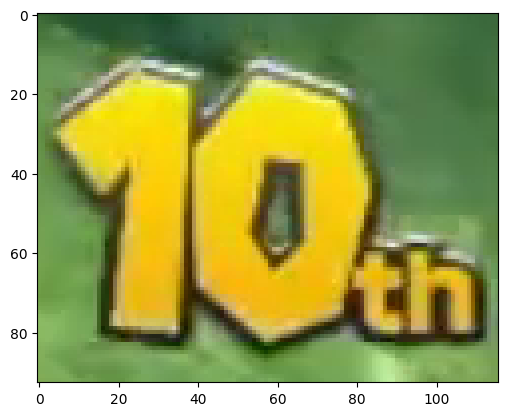

In [3]:
import matplotlib.pyplot as plt
import cv2

image_path = '/Users/shingkai/code/personal-projects/mk8/race_videos/training/donut_plains/p1_position/0/002801.png'

frame = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
predicted_class = predict_frame(frame)
print(f"Predicted class: {predicted_class}")


# Histogram Recognition

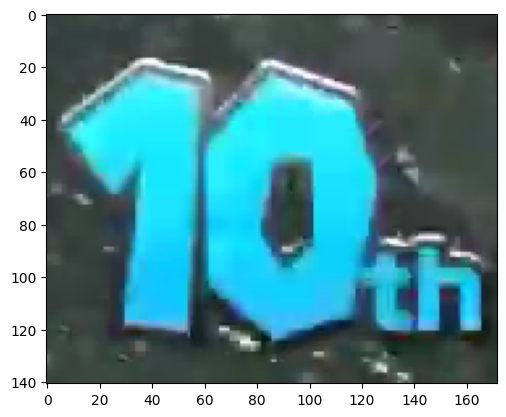

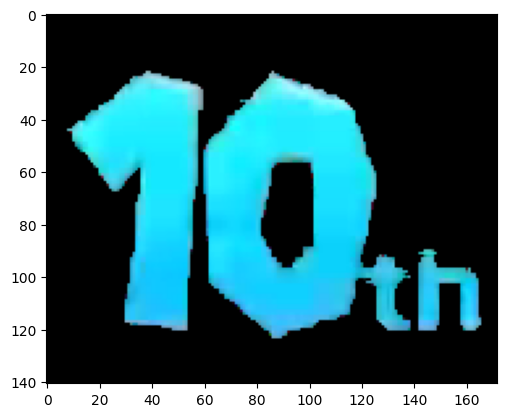

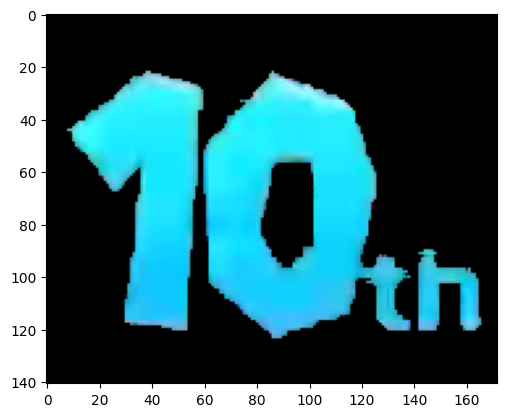

Similarity B: 0.999945216553417, G: 0.9986169807039942, R: 0.9988205728875419


In [18]:
import cv2
import matplotlib.pyplot as plt


image_path = '/Users/shingkai/code/personal-projects/mk8/training_data/positions/train/10/008809.png'
img = cv2.imread(image_path)

template_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/10.png'
template = cv2.imread(template_path)

mask_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/10_mask.png'
mask = cv2.imread(mask_path)


plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

masked_img = cv2.bitwise_and(img, mask)

plt.figure()
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.show()

masked_template = cv2.bitwise_and(template, mask)

plt.figure()
plt.imshow(cv2.cvtColor(masked_template, cv2.COLOR_BGR2RGB))
plt.show()


# Calculate the histogram for each color channel (B, G, R)
hist_b = cv2.calcHist([masked_img], [0], None, [256], [10, 256])
hist_g = cv2.calcHist([masked_img], [1], None, [256], [10, 256])
hist_r = cv2.calcHist([masked_img], [2], None, [256], [10, 256])



# Compare histograms between two images
hist_b2 = cv2.calcHist([masked_template], [0], None, [256], [10, 256])
hist_g2 = cv2.calcHist([masked_template], [1], None, [256], [10, 256])
hist_r2 = cv2.calcHist([masked_template], [2], None, [256], [10, 256])

# Use correlation or other similarity measures
b_sim = cv2.compareHist(hist_b, hist_b2, cv2.HISTCMP_CORREL)
g_sim = cv2.compareHist(hist_g, hist_g2, cv2.HISTCMP_CORREL)
r_sim = cv2.compareHist(hist_r, hist_r2, cv2.HISTCMP_CORREL)

print(f"Similarity B: {b_sim}, G: {g_sim}, R: {r_sim}")

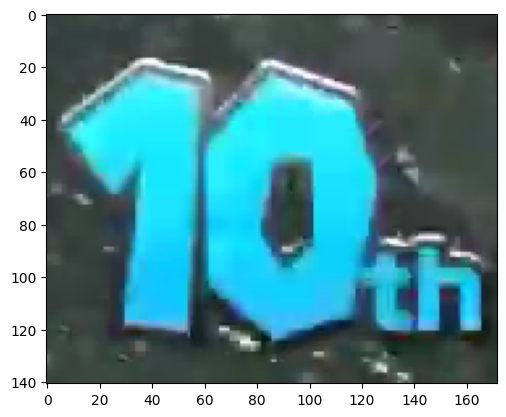

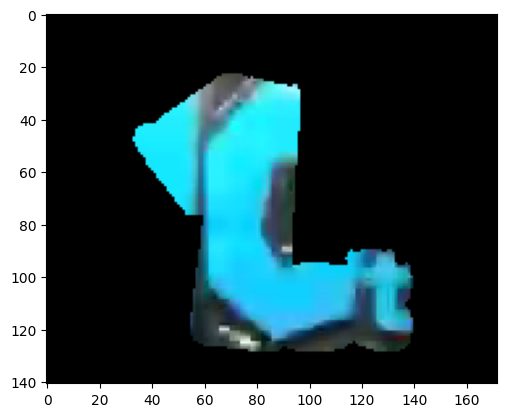

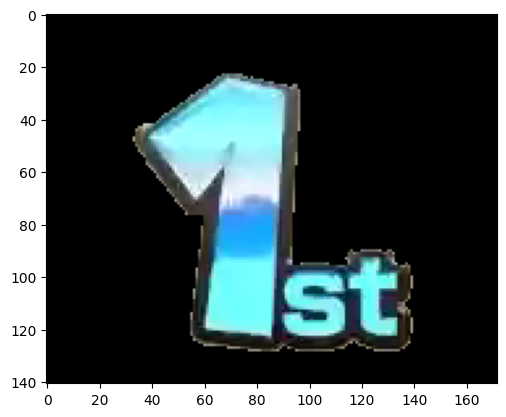

Similarity B: 0.9818624885197765, G: 0.11662263617651376, R: 0.3732459704383258


In [19]:
import cv2
import matplotlib.pyplot as plt


image_path = '/Users/shingkai/code/personal-projects/mk8/training_data/positions/train/10/008809.png'
img = cv2.imread(image_path)

# template_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/10.png'
template_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/01.png'
template = cv2.imread(template_path)

# mask_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/10_mask.png'
mask_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/01_mask.png'
mask = cv2.imread(mask_path)


plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

masked_img = cv2.bitwise_and(img, mask)

plt.figure()
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.show()

masked_template = cv2.bitwise_and(template, mask)

plt.figure()
plt.imshow(cv2.cvtColor(masked_template, cv2.COLOR_BGR2RGB))
plt.show()


# Calculate the histogram for each color channel (B, G, R)
hist_b = cv2.calcHist([masked_img], [0], None, [256], [10, 256])
hist_g = cv2.calcHist([masked_img], [1], None, [256], [10, 256])
hist_r = cv2.calcHist([masked_img], [2], None, [256], [10, 256])



# Compare histograms between two images
hist_b2 = cv2.calcHist([masked_template], [0], None, [256], [10, 256])
hist_g2 = cv2.calcHist([masked_template], [1], None, [256], [10, 256])
hist_r2 = cv2.calcHist([masked_template], [2], None, [256], [10, 256])

# Use correlation or other similarity measures
b_sim = cv2.compareHist(hist_b, hist_b2, cv2.HISTCMP_CORREL)
g_sim = cv2.compareHist(hist_g, hist_g2, cv2.HISTCMP_CORREL)
r_sim = cv2.compareHist(hist_r, hist_r2, cv2.HISTCMP_CORREL)

print(f"Similarity B: {b_sim}, G: {g_sim}, R: {r_sim}")

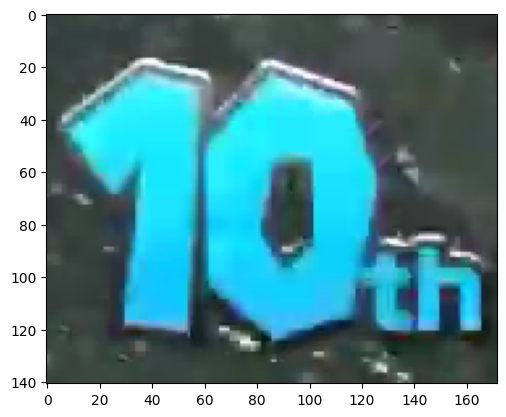

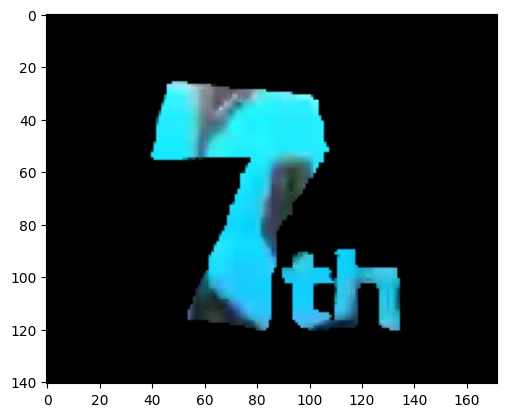

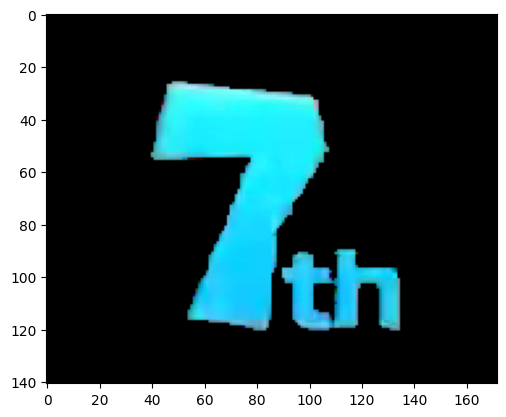

Similarity B: 0.9974244382105573, G: 0.8507579523793075, R: 0.9196298399315329


In [20]:
import cv2
import matplotlib.pyplot as plt


image_path = '/Users/shingkai/code/personal-projects/mk8/training_data/positions/train/10/008809.png'
img = cv2.imread(image_path)

# template_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/10.png'
template_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/07.png'
template = cv2.imread(template_path)

# mask_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/10_mask.png'
mask_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/07_mask.png'
mask = cv2.imread(mask_path)


plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

masked_img = cv2.bitwise_and(img, mask)

plt.figure()
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.show()

masked_template = cv2.bitwise_and(template, mask)

plt.figure()
plt.imshow(cv2.cvtColor(masked_template, cv2.COLOR_BGR2RGB))
plt.show()


# Calculate the histogram for each color channel (B, G, R)
hist_b = cv2.calcHist([masked_img], [0], None, [256], [10, 256])
hist_g = cv2.calcHist([masked_img], [1], None, [256], [10, 256])
hist_r = cv2.calcHist([masked_img], [2], None, [256], [10, 256])



# Compare histograms between two images
hist_b2 = cv2.calcHist([masked_template], [0], None, [256], [10, 256])
hist_g2 = cv2.calcHist([masked_template], [1], None, [256], [10, 256])
hist_r2 = cv2.calcHist([masked_template], [2], None, [256], [10, 256])

# Use correlation or other similarity measures
b_sim = cv2.compareHist(hist_b, hist_b2, cv2.HISTCMP_CORREL)
g_sim = cv2.compareHist(hist_g, hist_g2, cv2.HISTCMP_CORREL)
r_sim = cv2.compareHist(hist_r, hist_r2, cv2.HISTCMP_CORREL)

print(f"Similarity B: {b_sim}, G: {g_sim}, R: {r_sim}")

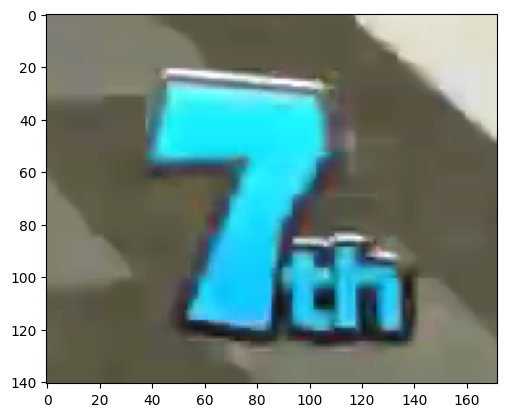

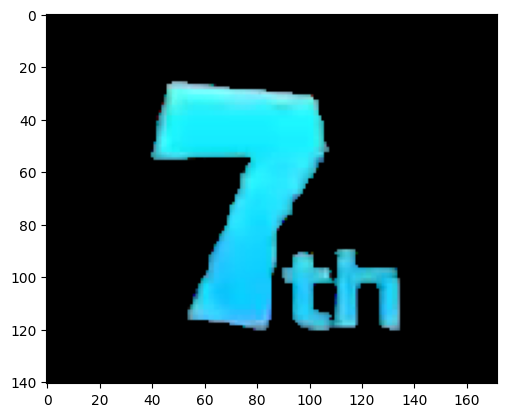

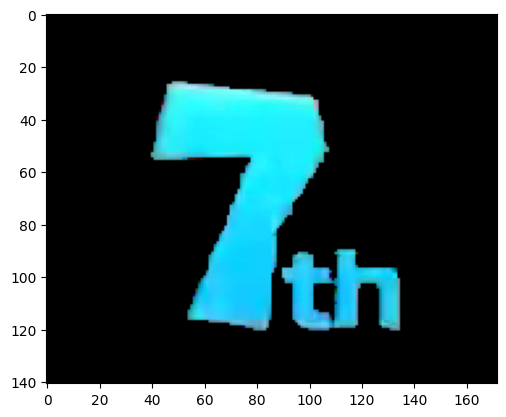

Similarity B: 0.9989247987595959, G: 0.9170839843416771, R: 0.8825623750555366


In [21]:
import cv2
import matplotlib.pyplot as plt


image_path = '/Users/shingkai/code/personal-projects/mk8/training_data/positions/train/07/001606.png'
img = cv2.imread(image_path)

# template_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/10.png'
template_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/07.png'
template = cv2.imread(template_path)

# mask_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/10_mask.png'
mask_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/07_mask.png'
mask = cv2.imread(mask_path)


plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

masked_img = cv2.bitwise_and(img, mask)

plt.figure()
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.show()

masked_template = cv2.bitwise_and(template, mask)

plt.figure()
plt.imshow(cv2.cvtColor(masked_template, cv2.COLOR_BGR2RGB))
plt.show()


# Calculate the histogram for each color channel (B, G, R)
hist_b = cv2.calcHist([masked_img], [0], None, [256], [10, 256])
hist_g = cv2.calcHist([masked_img], [1], None, [256], [10, 256])
hist_r = cv2.calcHist([masked_img], [2], None, [256], [10, 256])



# Compare histograms between two images
hist_b2 = cv2.calcHist([masked_template], [0], None, [256], [10, 256])
hist_g2 = cv2.calcHist([masked_template], [1], None, [256], [10, 256])
hist_r2 = cv2.calcHist([masked_template], [2], None, [256], [10, 256])

# Use correlation or other similarity measures
b_sim = cv2.compareHist(hist_b, hist_b2, cv2.HISTCMP_CORREL)
g_sim = cv2.compareHist(hist_g, hist_g2, cv2.HISTCMP_CORREL)
r_sim = cv2.compareHist(hist_r, hist_r2, cv2.HISTCMP_CORREL)

print(f"Similarity B: {b_sim}, G: {g_sim}, R: {r_sim}")

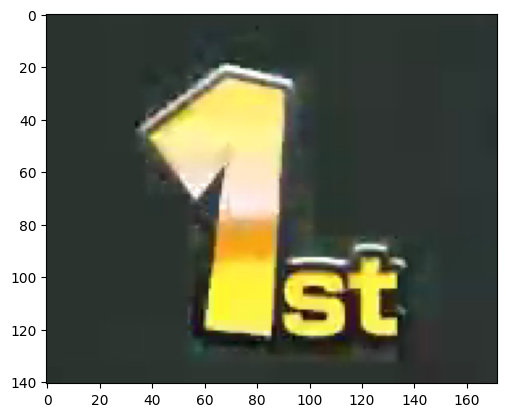

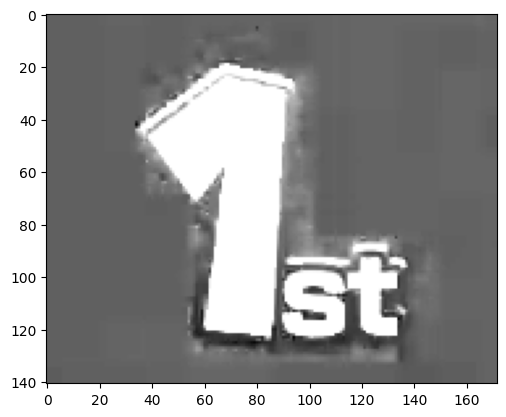

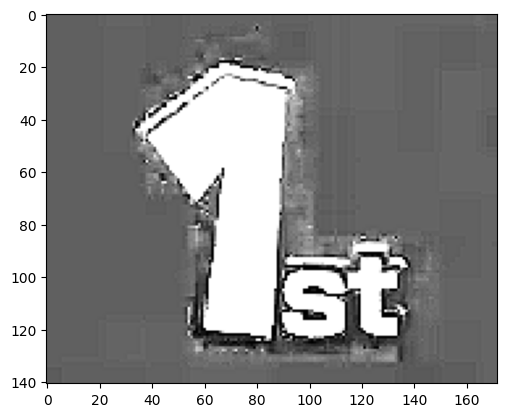

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-434.0..499.0].


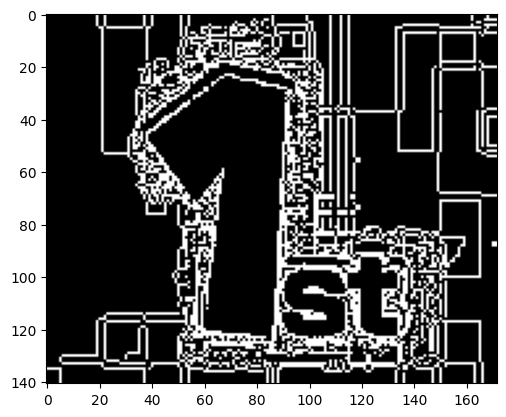

In [47]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


image_path = '/Users/shingkai/code/personal-projects/mk8/training_data/positions/p1/01.png'
img = cv2.imread(image_path)

# template_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/10.png'
template_path = '/Users/shingkai/code/personal-projects/mk8/training_data/positions/p2/01.png'
template = cv2.imread(template_path)


plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

alpha = 2.0
beta = 0

boosted = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
boosted = cv2.convertScaleAbs(boosted, alpha=alpha, beta=beta)

plt.figure()
plt.imshow(cv2.cvtColor(boosted, cv2.COLOR_BGR2RGB))
plt.show()


# Create the sharpening kernel 
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
  
# Sharpen the image 
sharpened_image = cv2.filter2D(boosted, -1, kernel) 
  
plt.figure()
plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
plt.show()

sharpened_image2 = cv2.Laplacian(cv2.cvtColor(boosted, cv2.COLOR_BGR2RGB), cv2.CV_64F) 

plt.figure()
plt.imshow(sharpened_image2)
plt.show()


/var/folders/cy/wrwx02w17cqc2zds1xjg55jc0000gn/T/ipykernel_83242/3864281419.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


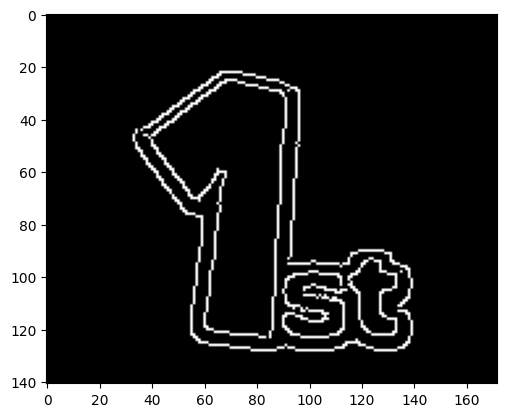

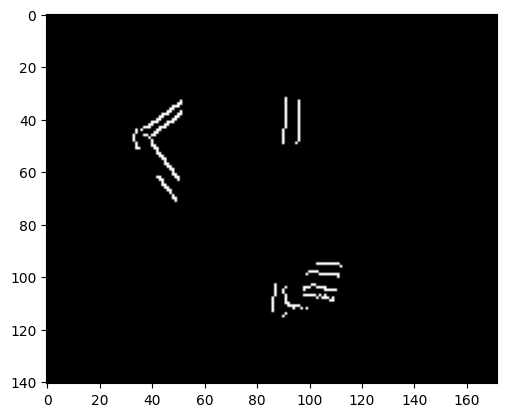

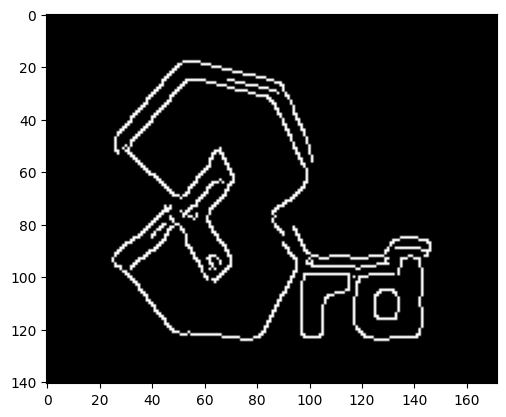

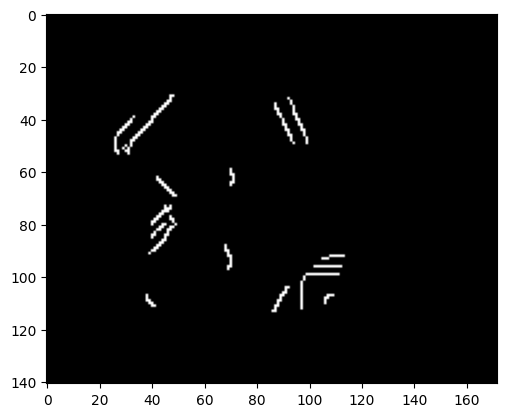

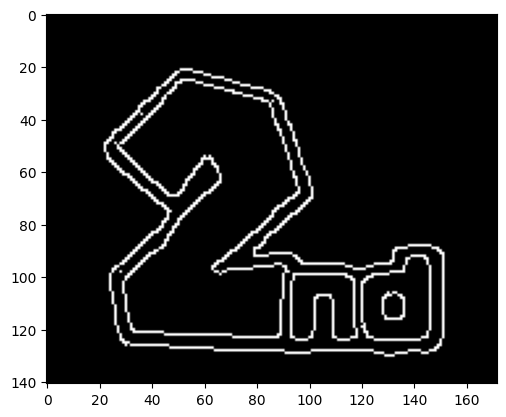

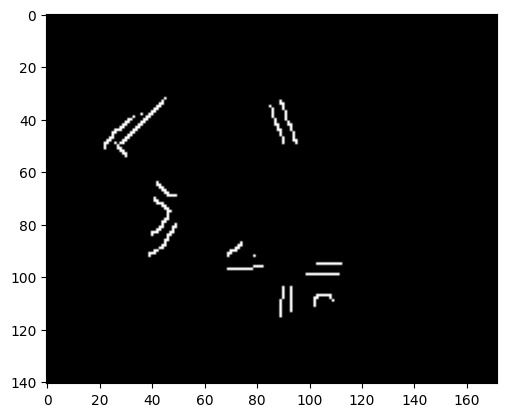

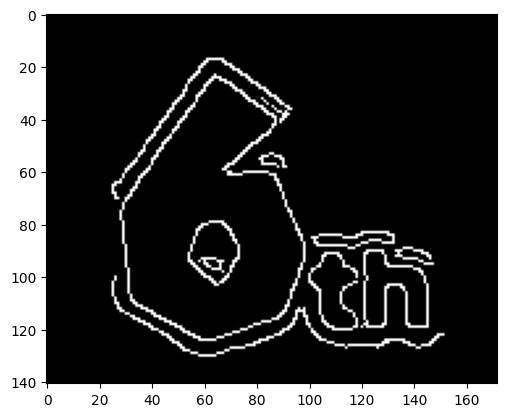

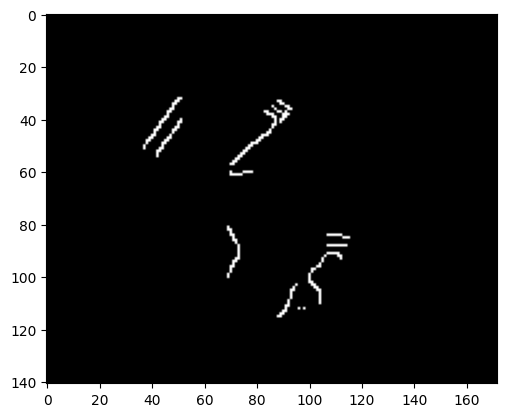

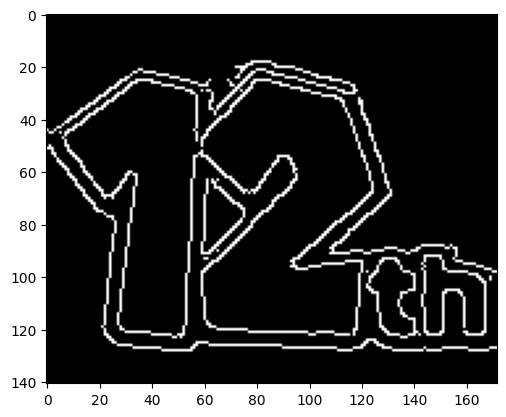

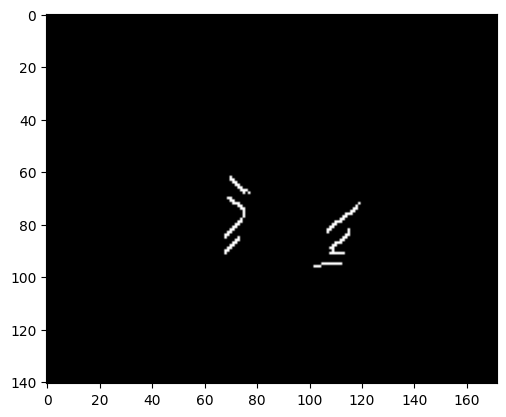

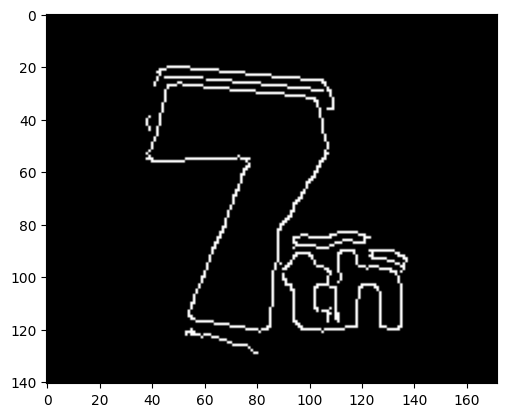

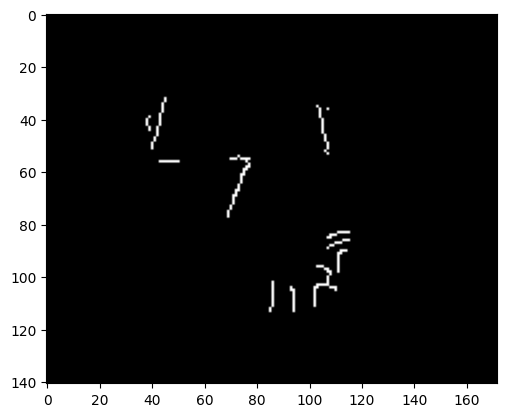

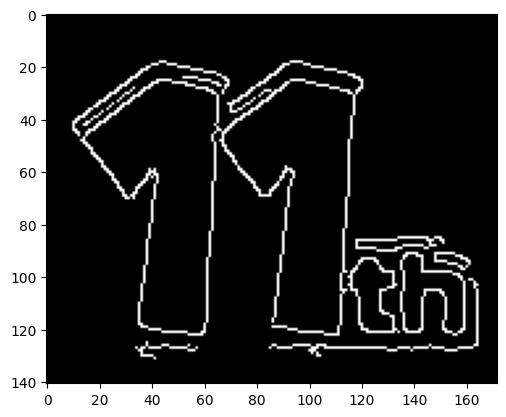

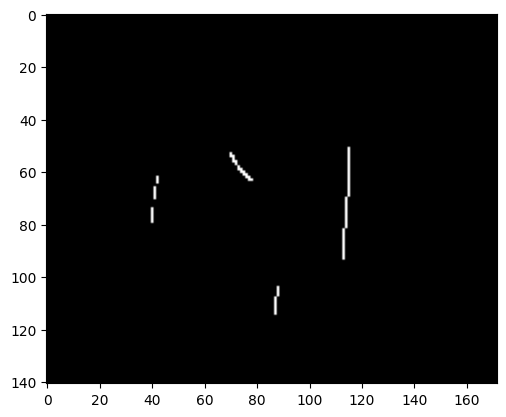

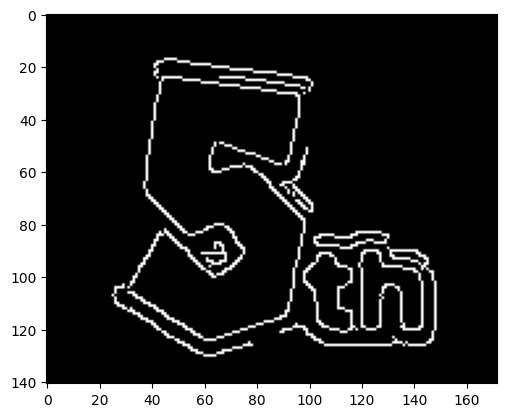

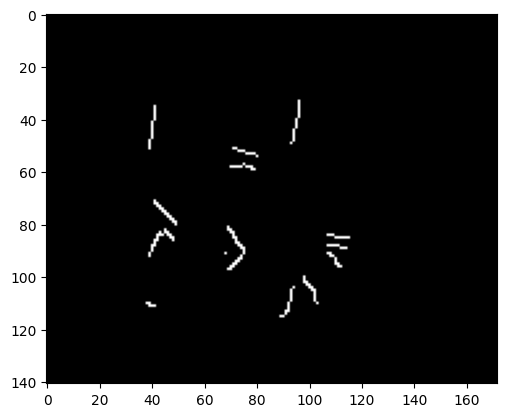

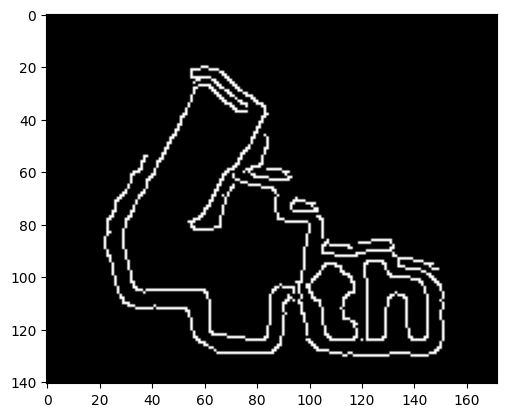

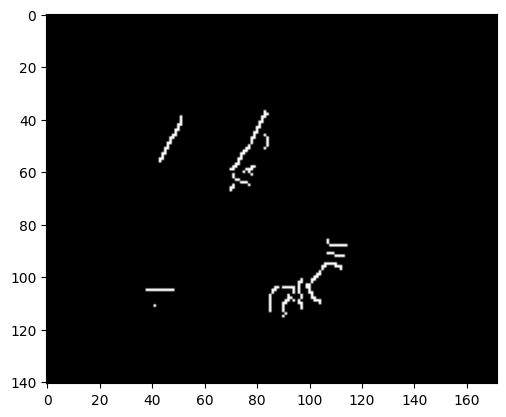

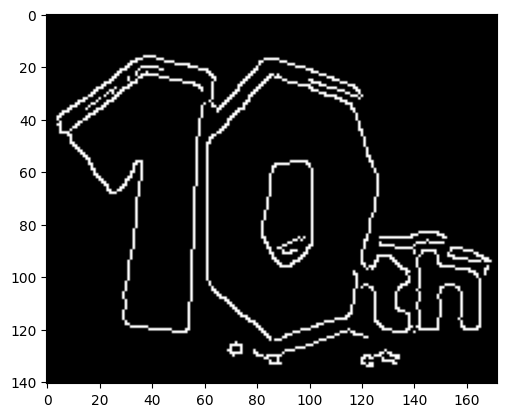

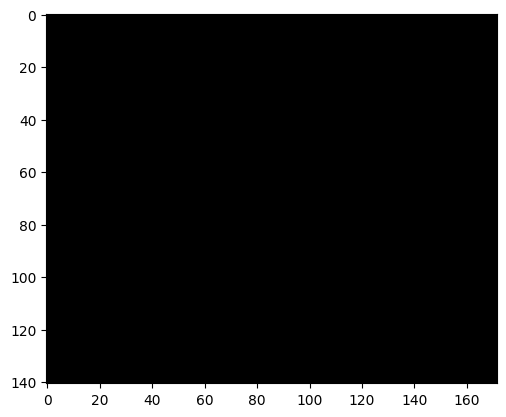

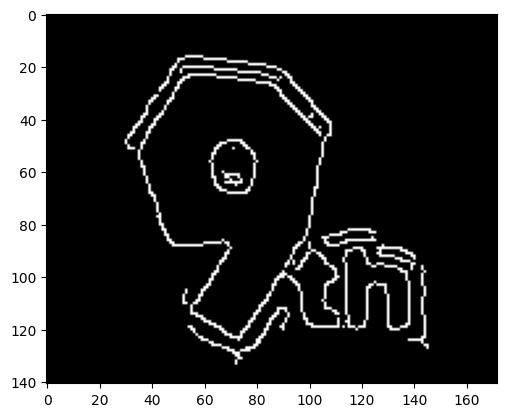

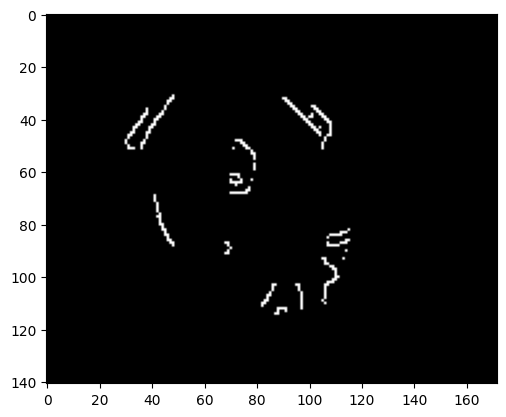

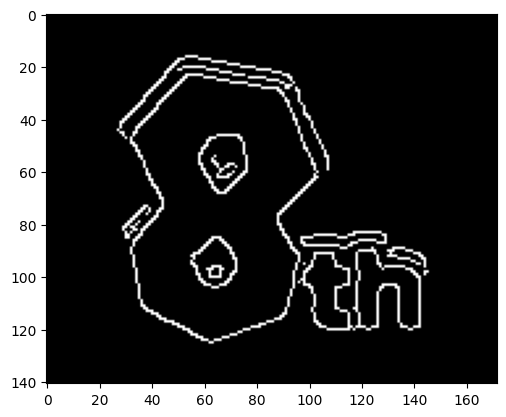

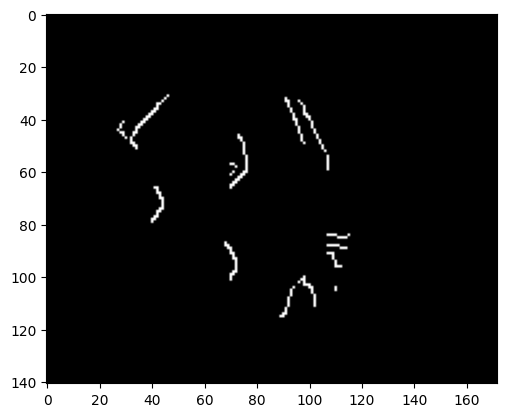

In [73]:
import os
import cv2
import matplotlib.pyplot as plt


base_path = '/Users/shingkai/code/personal-projects/mk8/training_data/positions/p2/'

for file in os.listdir(base_path):
    if file.endswith('.png') and not file.endswith('mask.png'):

        img = cv2.imread(os.path.join(base_path, file), 0)
        # plt.figure()
        # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        alpha = 1.5
        beta = 0
        boosted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
        # plt.figure()
        # plt.imshow(cv2.cvtColor(boosted, cv2.COLOR_BGR2RGB))

        # sharpened = cv2.Laplacian(cv2.cvtColor(boosted, cv2.COLOR_BGR2RGB), cv2.CV_64F)
        # plt.figure()
        # plt.imshow(sharpened)

        blurred = cv2.GaussianBlur(boosted, (5, 5), 1.5)
        canny = cv2.Canny(blurred, threshold1=50, threshold2=150)
        plt.figure()
        plt.imshow(cv2.cvtColor(canny, cv2.COLOR_BGR2RGB))

        mask = cv2.imread('/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/10_tight_mask.png',0)
        masked_canny = cv2.bitwise_and(canny, mask)
        plt.figure()
        plt.imshow(cv2.cvtColor(masked_canny, cv2.COLOR_BGR2RGB))


plt.show()

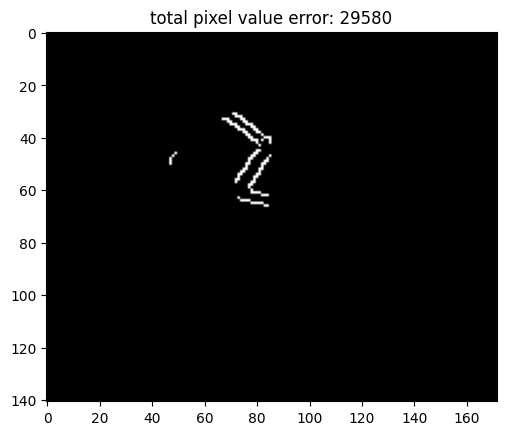

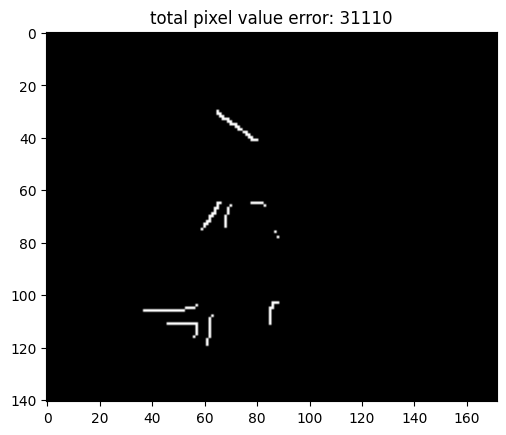

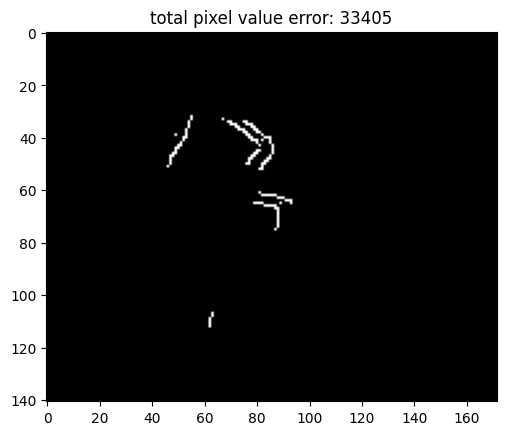

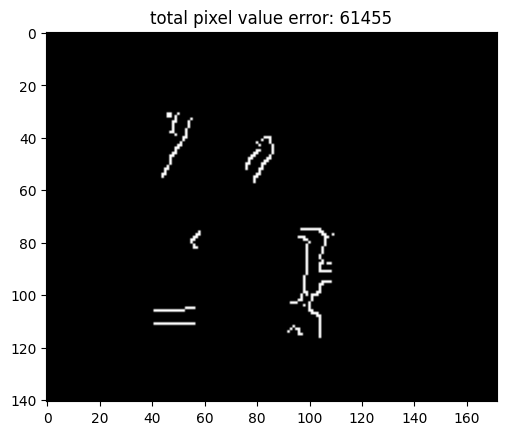

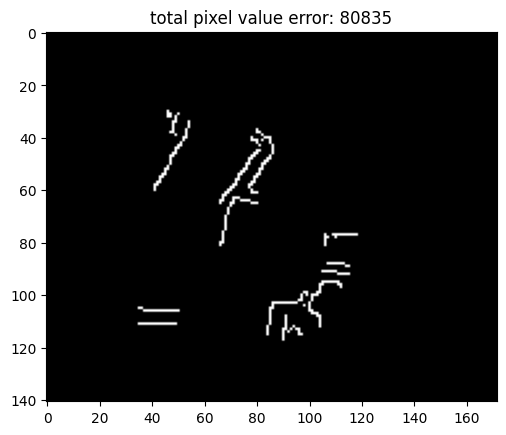

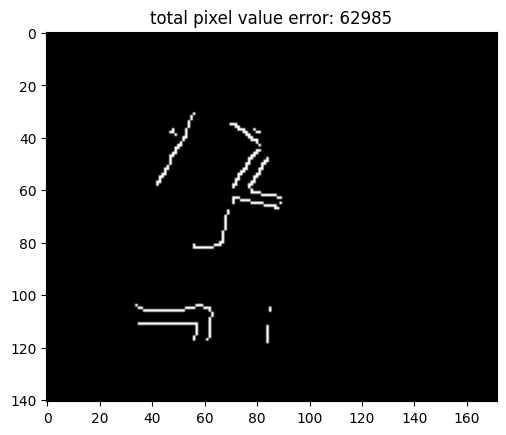

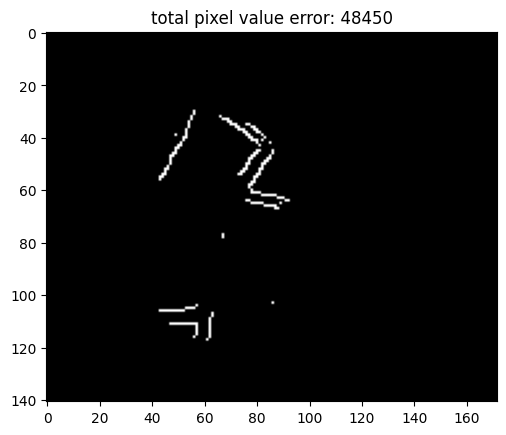

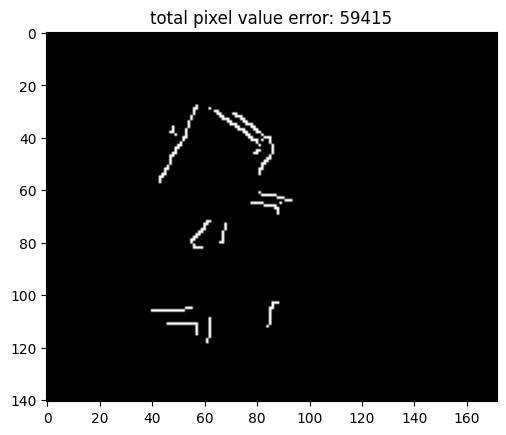

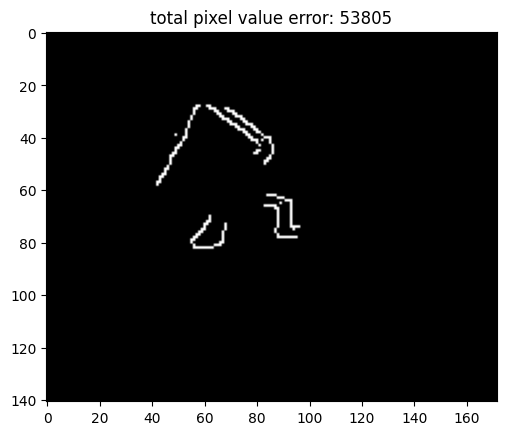

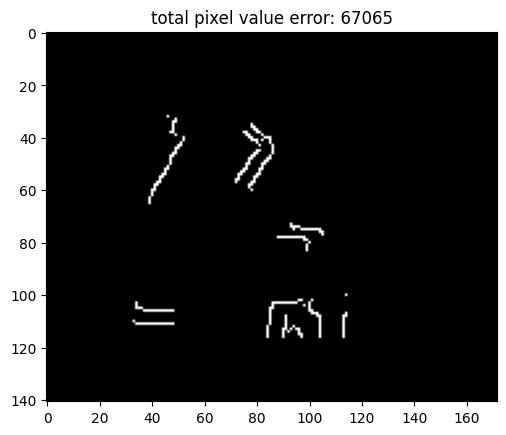

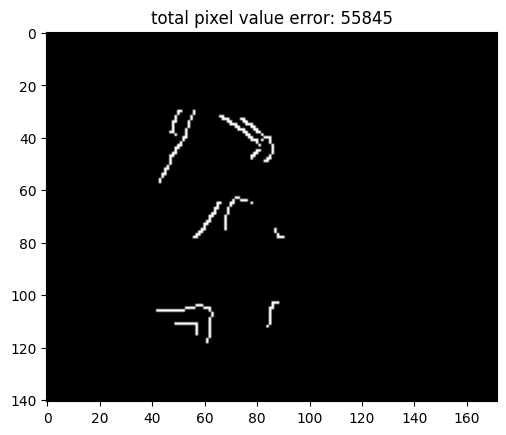

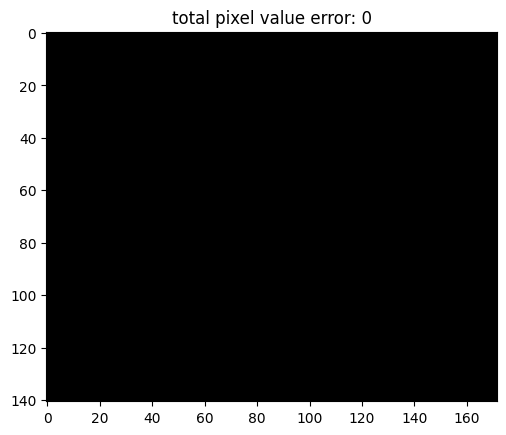

Best mask: 04_mask.png with error: 0


In [14]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('/Users/shingkai/code/personal-projects/mk8/training_data/positions/train/04/002985.png',0)
boosted = cv2.convertScaleAbs(img, alpha=1.5, beta=0)
blurred = cv2.GaussianBlur(boosted, (5, 5), 1.5)
canny = cv2.Canny(blurred, threshold1=50, threshold2=150)
# plt.figure()
# plt.imshow(cv2.cvtColor(canny, cv2.COLOR_BGR2RGB))

mask_path = '/Users/shingkai/code/personal-projects/mk8/MarioKart8CV/templates/position/edges/'

min_error = None
best_mask = None

for file in os.listdir(mask_path):
    if file.endswith('mask.png'):
        mask = cv2.imread(os.path.join(mask_path, file),0)
        # plt.figure()
        # plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        
        masked_canny = cv2.bitwise_and(canny, mask)

        error = np.sum(masked_canny)
        if min_error == None or min_error > error:
            min_error = error
            best_mask = file

        plt.figure()
        plt.imshow(cv2.cvtColor(masked_canny, cv2.COLOR_BGR2RGB))
        plt.title(f"total pixel value error: {np.sum(masked_canny)}")
        # print(f"total pixel value error: {np.sum(masked_canny)}")

plt.show()

print(f"Best mask: {best_mask} with error: {min_error}")